<a href="https://colab.research.google.com/github/valeriocardoso/learning-area/blob/master/Machine_Learning/Time_Series/Forecasting_with_sktime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install sktime pmdarima

     |████████████████████████████████| 1.5MB 4.3MB/s 
     |████████████████████████████████| 2.1MB 10.2MB/s 
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sktime.datasets import load_airline
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import smape_loss
from sktime.utils.plotting.forecasting import plot_ys

%matplotlib inline

In [12]:
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=36)
print(y_train.shape[0], y_test.shape[0])

108 36


0.14008272913734346

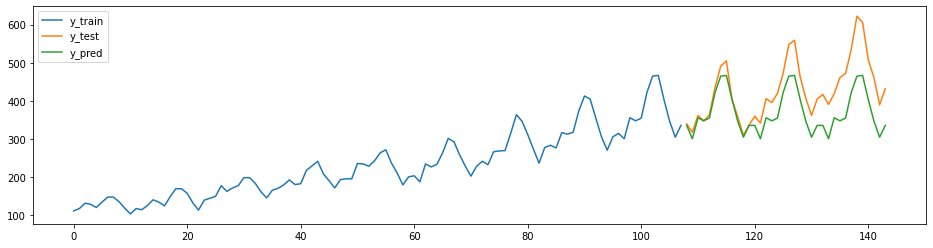

In [13]:

from sktime.forecasting.compose import ReducedRegressionForecaster
from sklearn.neighbors import KNeighborsRegressor

regressor = KNeighborsRegressor(n_neighbors=1)
forecaster = ReducedRegressionForecaster(regressor=regressor, window_length=12, strategy="recursive")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

In [14]:
from sktime.forecasting.model_selection import SlidingWindowSplitter
cv = SlidingWindowSplitter(window_length=10, start_with_window=True)
for input_window, output_window in cv.split(y_train.iloc[:20]):
    print(input_window, output_window)

[0 1 2 3 4 5 6 7 8 9] [10]
[ 1  2  3  4  5  6  7  8  9 10] [11]
[ 2  3  4  5  6  7  8  9 10 11] [12]
[ 3  4  5  6  7  8  9 10 11 12] [13]
[ 4  5  6  7  8  9 10 11 12 13] [14]
[ 5  6  7  8  9 10 11 12 13 14] [15]
[ 6  7  8  9 10 11 12 13 14 15] [16]
[ 7  8  9 10 11 12 13 14 15 16] [17]
[ 8  9 10 11 12 13 14 15 16 17] [18]
[ 9 10 11 12 13 14 15 16 17 18] [19]


0.05106126665215278

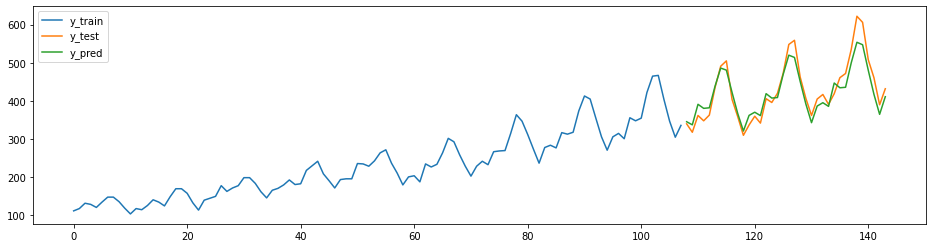

In [15]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
forecaster = ExponentialSmoothing(trend="add", seasonal="multiplicative", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

0.04117062368222738

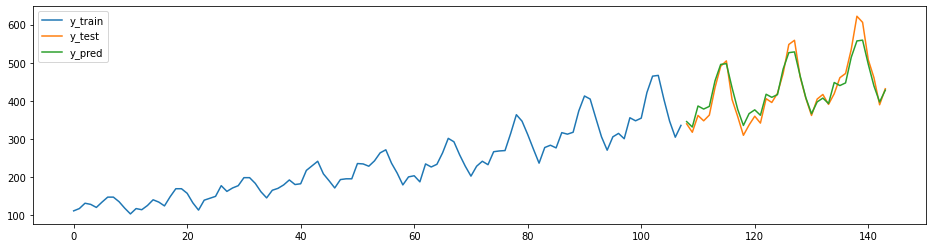

In [19]:
from sktime.forecasting.arima import AutoARIMA
forecaster = AutoARIMA(sp=12, suppress_warnings=True)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

0.07021244478214374

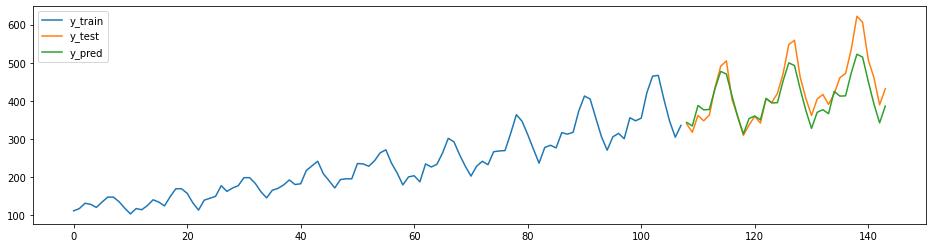

In [20]:
from sktime.forecasting.compose import EnsembleForecaster
forecaster = EnsembleForecaster([
    ("ses", ExponentialSmoothing(seasonal="multiplicative", sp=12)),
    ("holt", ExponentialSmoothing(trend="add", damped=False, seasonal="multiplicative", sp=12)),
    ("damped", ExponentialSmoothing(trend="add", damped=True, seasonal="multiplicative", sp=12))
])
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

In [23]:
from sktime.forecasting.model_selection import ForecastingGridSearchCV

forecaster = ReducedRegressionForecaster(regressor=regressor, window_length=15, strategy="recursive")
param_grid = {"window_length": [5, 10, 15]}

# we fit the forecaster on the initial window, and then use temporal cross-validation to find the optimal parameter
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid)
gscv.fit(y_train)
y_pred = gscv.predict(fh)

0.14187443909112035

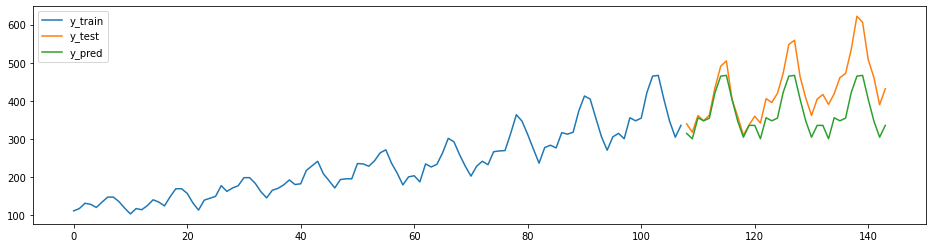

In [24]:
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

In [25]:
gscv.best_params_

{'window_length': 15}

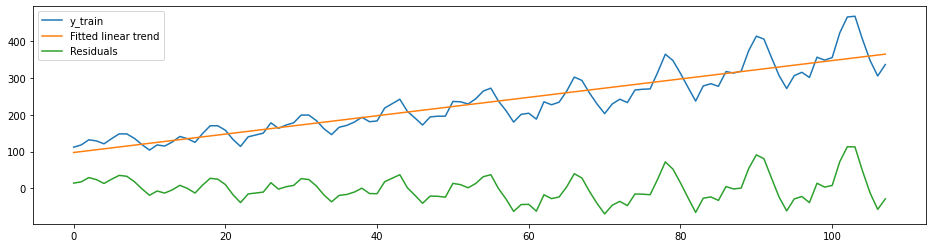

In [26]:
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformers.single_series.detrend import Detrender

# liner detrending
forecaster = PolynomialTrendForecaster(degree=1)
transformer = Detrender(forecaster=forecaster)
yt = transformer.fit_transform(y_train)

# internally, the Detrender uses the in-sample predictions of the PolynomialTrendForecaster
forecaster = PolynomialTrendForecaster(degree=1)
fh_ins = -np.arange(len(y_train)) # in-sample forecasting horizon
y_pred = forecaster.fit(y_train).predict(fh=fh_ins)

plot_ys(y_train, y_pred, yt, labels=["y_train", "Fitted linear trend", "Residuals"]);

0.04038731595566061

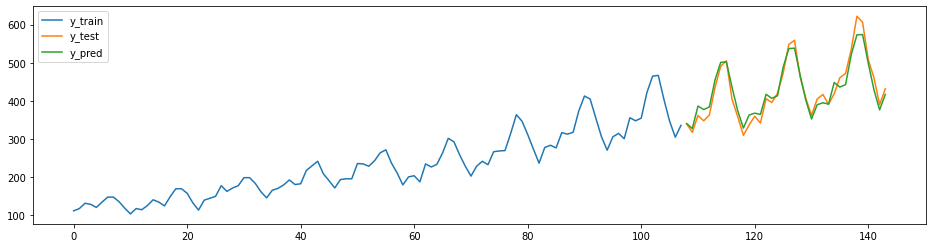

In [27]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformers.single_series.detrend import Deseasonalizer

forecaster = TransformedTargetForecaster([
    ("deseasonalise", Deseasonalizer(model="multiplicative", sp=12)),
    ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
    ("forecast", ReducedRegressionForecaster(regressor=regressor, window_length=15, strategy="recursive"))
])
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

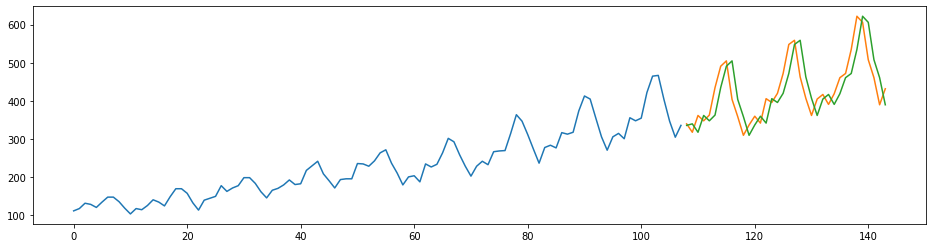

In [28]:
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)
cv = SlidingWindowSplitter(fh=1)
y_pred = forecaster.update_predict(y_test, cv)
smape_loss(y_test, y_pred)
plot_ys(y_train, y_test, y_pred);

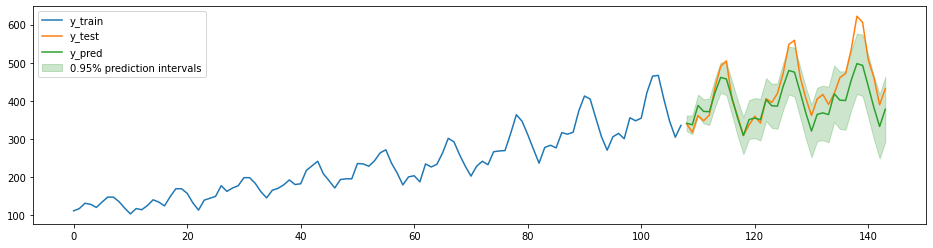

In [29]:
from sktime.forecasting.theta import ThetaForecaster
forecaster = ThetaForecaster(sp=12)
forecaster.fit(y_train)
alpha = 0.05  # 95% prediction intervals
y_pred, pred_ints = forecaster.predict(fh, return_pred_int=True, alpha=alpha)
smape_loss(y_test, y_pred)

fig, ax = plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
ax.fill_between(y_pred.index, pred_ints["lower"], pred_ints["upper"], alpha=0.2, color="green", label=f"{1 - alpha}% prediction intervals")
plt.legend();